# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

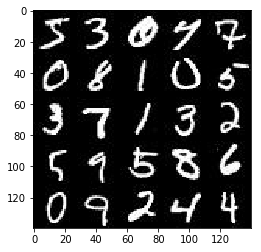

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

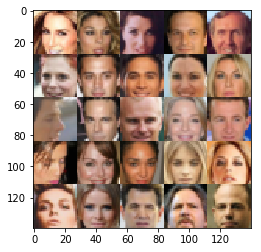

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # Define alpha
        alpha = 0.2
        
        # Hidden layer 1
        hidden_1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        hidden_1 = tf.maximum(alpha * hidden_1, hidden_1)
        
        # Hidden layer 2
        hidden_2 = tf.layers.conv2d(hidden_1, 128, 5, 2, 'same')
        hidden_2 = tf.layers.batch_normalization(hidden_2, training=True)
        hidden_2 = tf.maximum(alpha * hidden_2, hidden_2)
        
        # Hidden layer 3
        hidden_3 = tf.layers.conv2d(hidden_2, 256, 5, 2, 'same')
        hidden_3 = tf.layers.batch_normalization(hidden_3, training=True)
        hidden_3 = tf.maximum(alpha * hidden_3, hidden_3)
        
        # Flatten
        flat = tf.reshape(hidden_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Define alpha
        alpha = 0.2
        # Hidden layer 1
        hidden_1 = tf.layers.dense(z, 2*2*512)
        hidden_1 = tf.reshape(hidden_1, (-1, 2, 2, 512))
        hidden_1 = tf.maximum(alpha * hidden_1, hidden_1)
        
        # Hidden layer 2
        hidden_2 = tf.layers.conv2d_transpose(hidden_1, 256, 5, 2, 'valid')
        hidden_2 = tf.layers.batch_normalization(hidden_2, training=is_train)
        hidden_2 = tf.maximum(alpha * hidden_2, hidden_2)

        # Hidden layer 3
        hidden_3 = tf.layers.conv2d_transpose(hidden_2, 128, 5, 2, 'same')
        hidden_3 = tf.layers.batch_normalization(hidden_3, training=is_train)
        hidden_3 = tf.maximum(alpha * hidden_3, hidden_3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(hidden_3, out_channel_dim, 5, 2, padding='same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()    

    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    num_samples, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2.
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, img_channels, data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.8862... Generator Loss: 8.0534
Epoch 0/2... Discriminator Loss: 1.5557... Generator Loss: 5.0629
Epoch 0/2... Discriminator Loss: 1.1321... Generator Loss: 3.7710
Epoch 0/2... Discriminator Loss: 0.9014... Generator Loss: 0.9664
Epoch 0/2... Discriminator Loss: 1.1002... Generator Loss: 1.1662


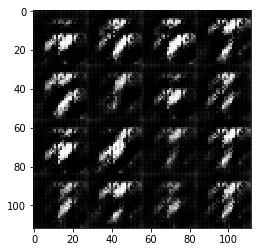

Epoch 0/2... Discriminator Loss: 0.6683... Generator Loss: 2.1534
Epoch 0/2... Discriminator Loss: 1.1247... Generator Loss: 0.7455
Epoch 0/2... Discriminator Loss: 1.3210... Generator Loss: 0.6122
Epoch 0/2... Discriminator Loss: 0.8627... Generator Loss: 2.2599
Epoch 0/2... Discriminator Loss: 0.9506... Generator Loss: 2.0654


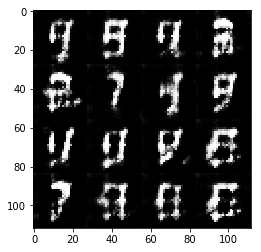

Epoch 0/2... Discriminator Loss: 1.2054... Generator Loss: 1.0236
Epoch 0/2... Discriminator Loss: 1.1804... Generator Loss: 2.6097
Epoch 0/2... Discriminator Loss: 1.0757... Generator Loss: 1.5013
Epoch 0/2... Discriminator Loss: 1.5322... Generator Loss: 0.4838
Epoch 0/2... Discriminator Loss: 1.2280... Generator Loss: 1.8171


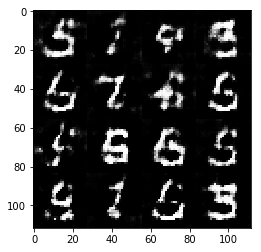

Epoch 0/2... Discriminator Loss: 1.1856... Generator Loss: 1.8251
Epoch 0/2... Discriminator Loss: 1.1573... Generator Loss: 1.2492
Epoch 0/2... Discriminator Loss: 1.3730... Generator Loss: 0.6296
Epoch 0/2... Discriminator Loss: 1.2307... Generator Loss: 0.6734
Epoch 0/2... Discriminator Loss: 1.2220... Generator Loss: 1.0318


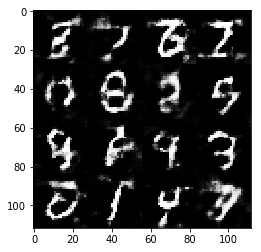

Epoch 0/2... Discriminator Loss: 1.1474... Generator Loss: 1.1531
Epoch 0/2... Discriminator Loss: 1.2007... Generator Loss: 0.7168
Epoch 0/2... Discriminator Loss: 1.1367... Generator Loss: 0.7280
Epoch 0/2... Discriminator Loss: 1.1791... Generator Loss: 0.8946
Epoch 0/2... Discriminator Loss: 1.1659... Generator Loss: 1.7109


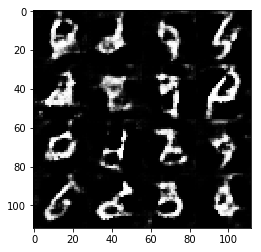

Epoch 0/2... Discriminator Loss: 1.1220... Generator Loss: 0.8673
Epoch 0/2... Discriminator Loss: 1.1585... Generator Loss: 1.4688
Epoch 0/2... Discriminator Loss: 1.1244... Generator Loss: 0.8255
Epoch 0/2... Discriminator Loss: 1.5052... Generator Loss: 0.4435
Epoch 0/2... Discriminator Loss: 1.1138... Generator Loss: 1.5427


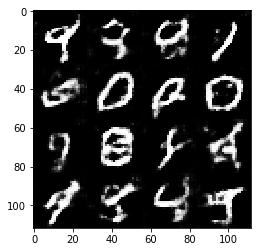

Epoch 0/2... Discriminator Loss: 1.1557... Generator Loss: 1.3370
Epoch 0/2... Discriminator Loss: 1.1431... Generator Loss: 0.9981
Epoch 0/2... Discriminator Loss: 1.1096... Generator Loss: 0.9652
Epoch 0/2... Discriminator Loss: 1.4765... Generator Loss: 0.4959
Epoch 0/2... Discriminator Loss: 1.1951... Generator Loss: 1.5452


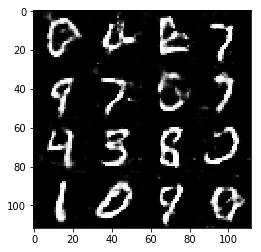

Epoch 0/2... Discriminator Loss: 1.6125... Generator Loss: 0.4102
Epoch 0/2... Discriminator Loss: 1.5787... Generator Loss: 0.4265
Epoch 0/2... Discriminator Loss: 1.0795... Generator Loss: 1.4184
Epoch 0/2... Discriminator Loss: 1.1902... Generator Loss: 1.1790
Epoch 0/2... Discriminator Loss: 1.2406... Generator Loss: 1.2660


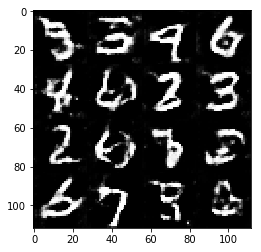

Epoch 0/2... Discriminator Loss: 1.2236... Generator Loss: 1.9122
Epoch 0/2... Discriminator Loss: 1.0406... Generator Loss: 0.7890
Epoch 0/2... Discriminator Loss: 2.2904... Generator Loss: 0.3115
Epoch 0/2... Discriminator Loss: 1.0474... Generator Loss: 0.9621
Epoch 0/2... Discriminator Loss: 1.1039... Generator Loss: 1.4767


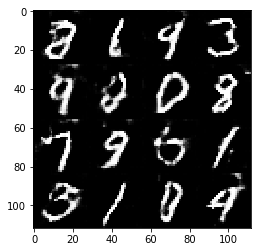

Epoch 0/2... Discriminator Loss: 1.1955... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 1.5111
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.9827


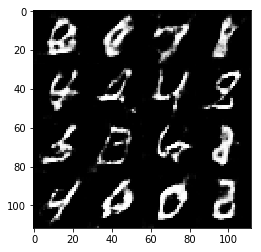

Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.6061
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.4222
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.0740


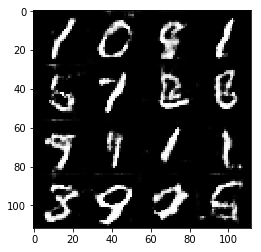

Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.1404
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 2.4822
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 2.2071... Generator Loss: 0.2109
Epoch 1/2... Discriminator Loss: 2.0025... Generator Loss: 0.2452


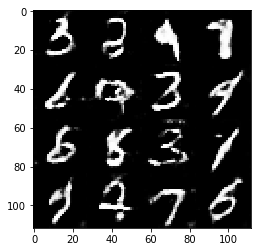

Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.7467
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 2.9003


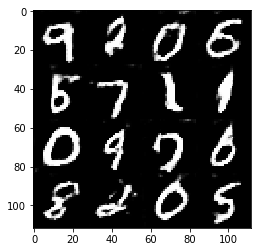

Epoch 1/2... Discriminator Loss: 2.2299... Generator Loss: 2.6928
Epoch 1/2... Discriminator Loss: 2.2239... Generator Loss: 2.9522
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 1.9135


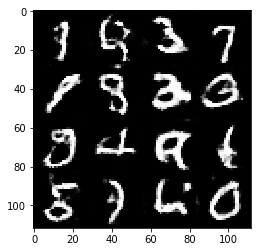

Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 1.7121
Epoch 1/2... Discriminator Loss: 1.7420... Generator Loss: 0.3663
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.0975


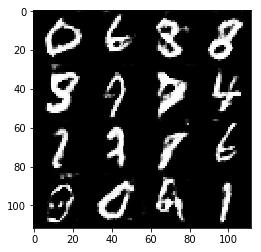

Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.8107
Epoch 1/2... Discriminator Loss: 1.9780... Generator Loss: 0.2940
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.5514


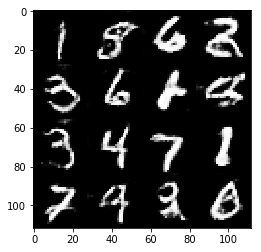

Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 2.3421
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.5136


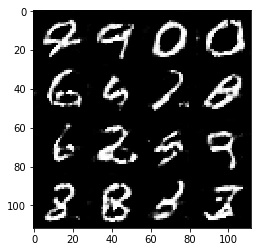

Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 1.5674
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 1.6584
Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.3564


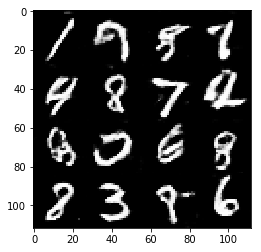

Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.9918
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.1510


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.3109... Generator Loss: 0.8321
Epoch 0/1... Discriminator Loss: 0.7457... Generator Loss: 1.5134
Epoch 0/1... Discriminator Loss: 0.5773... Generator Loss: 2.1364
Epoch 0/1... Discriminator Loss: 0.4189... Generator Loss: 3.6325
Epoch 0/1... Discriminator Loss: 0.4957... Generator Loss: 2.6405


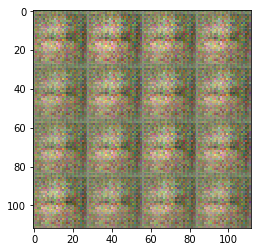

Epoch 0/1... Discriminator Loss: 0.5769... Generator Loss: 1.7349
Epoch 0/1... Discriminator Loss: 0.4754... Generator Loss: 3.4187
Epoch 0/1... Discriminator Loss: 0.5123... Generator Loss: 2.4731
Epoch 0/1... Discriminator Loss: 0.4784... Generator Loss: 2.5153
Epoch 0/1... Discriminator Loss: 0.4276... Generator Loss: 3.3419


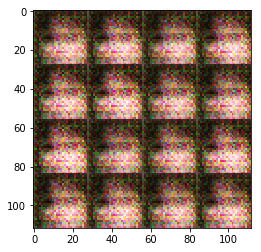

Epoch 0/1... Discriminator Loss: 0.4433... Generator Loss: 3.1391
Epoch 0/1... Discriminator Loss: 0.4130... Generator Loss: 3.1468
Epoch 0/1... Discriminator Loss: 0.3962... Generator Loss: 3.7273
Epoch 0/1... Discriminator Loss: 0.3842... Generator Loss: 3.8934
Epoch 0/1... Discriminator Loss: 0.3932... Generator Loss: 3.5442


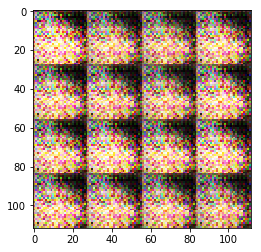

Epoch 0/1... Discriminator Loss: 0.4326... Generator Loss: 3.0356
Epoch 0/1... Discriminator Loss: 0.5664... Generator Loss: 2.9822
Epoch 0/1... Discriminator Loss: 0.6315... Generator Loss: 2.6507
Epoch 0/1... Discriminator Loss: 0.6067... Generator Loss: 2.1825
Epoch 0/1... Discriminator Loss: 0.5913... Generator Loss: 1.9293


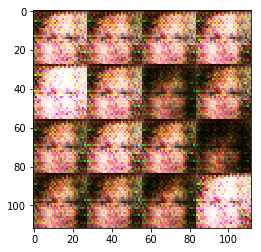

Epoch 0/1... Discriminator Loss: 0.4884... Generator Loss: 2.8811
Epoch 0/1... Discriminator Loss: 0.9053... Generator Loss: 5.8856
Epoch 0/1... Discriminator Loss: 0.7219... Generator Loss: 1.3547
Epoch 0/1... Discriminator Loss: 0.4916... Generator Loss: 2.9107
Epoch 0/1... Discriminator Loss: 0.5515... Generator Loss: 2.5775


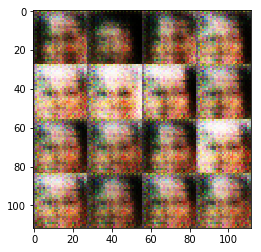

Epoch 0/1... Discriminator Loss: 0.5915... Generator Loss: 2.4171
Epoch 0/1... Discriminator Loss: 0.5804... Generator Loss: 2.0003
Epoch 0/1... Discriminator Loss: 0.8001... Generator Loss: 1.1859
Epoch 0/1... Discriminator Loss: 0.6055... Generator Loss: 2.1905
Epoch 0/1... Discriminator Loss: 0.6390... Generator Loss: 1.7875


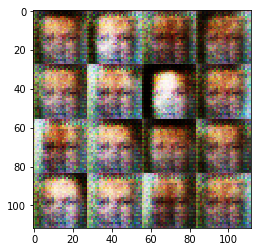

Epoch 0/1... Discriminator Loss: 0.7654... Generator Loss: 1.7416
Epoch 0/1... Discriminator Loss: 0.7574... Generator Loss: 1.3703
Epoch 0/1... Discriminator Loss: 0.5256... Generator Loss: 2.4263
Epoch 0/1... Discriminator Loss: 0.8974... Generator Loss: 1.6644
Epoch 0/1... Discriminator Loss: 0.6852... Generator Loss: 1.5040


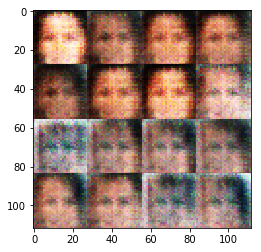

Epoch 0/1... Discriminator Loss: 0.7144... Generator Loss: 1.8378
Epoch 0/1... Discriminator Loss: 0.7007... Generator Loss: 1.7541
Epoch 0/1... Discriminator Loss: 0.9843... Generator Loss: 1.1909
Epoch 0/1... Discriminator Loss: 0.8602... Generator Loss: 1.0465
Epoch 0/1... Discriminator Loss: 1.0214... Generator Loss: 0.9355


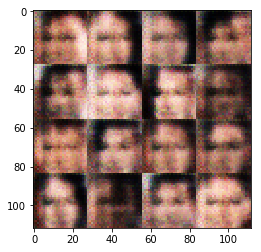

Epoch 0/1... Discriminator Loss: 1.0571... Generator Loss: 0.9739
Epoch 0/1... Discriminator Loss: 0.9123... Generator Loss: 1.2439
Epoch 0/1... Discriminator Loss: 0.8575... Generator Loss: 1.6798
Epoch 0/1... Discriminator Loss: 1.1346... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.0859... Generator Loss: 1.0393


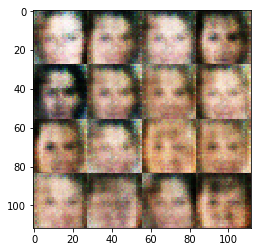

Epoch 0/1... Discriminator Loss: 1.0979... Generator Loss: 1.0840
Epoch 0/1... Discriminator Loss: 1.1574... Generator Loss: 0.8999
Epoch 0/1... Discriminator Loss: 1.0421... Generator Loss: 1.0519
Epoch 0/1... Discriminator Loss: 1.3158... Generator Loss: 0.8574
Epoch 0/1... Discriminator Loss: 1.0665... Generator Loss: 1.1864


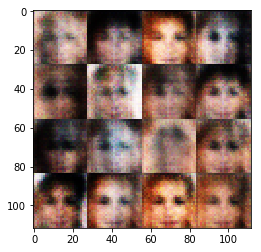

Epoch 0/1... Discriminator Loss: 1.1027... Generator Loss: 0.9269
Epoch 0/1... Discriminator Loss: 0.9192... Generator Loss: 1.7876
Epoch 0/1... Discriminator Loss: 1.5602... Generator Loss: 1.1291
Epoch 0/1... Discriminator Loss: 1.0803... Generator Loss: 1.1630
Epoch 0/1... Discriminator Loss: 0.9254... Generator Loss: 1.4628


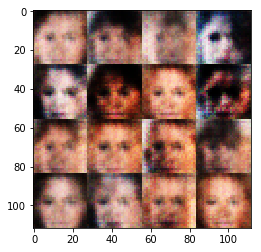

Epoch 0/1... Discriminator Loss: 1.1576... Generator Loss: 1.9798
Epoch 0/1... Discriminator Loss: 1.0311... Generator Loss: 1.1855
Epoch 0/1... Discriminator Loss: 1.0074... Generator Loss: 1.0211
Epoch 0/1... Discriminator Loss: 1.1017... Generator Loss: 0.9995
Epoch 0/1... Discriminator Loss: 1.0122... Generator Loss: 0.9702


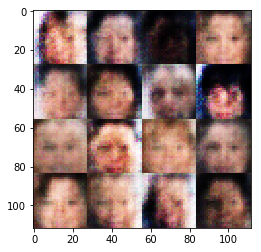

Epoch 0/1... Discriminator Loss: 1.0406... Generator Loss: 1.3186
Epoch 0/1... Discriminator Loss: 0.9755... Generator Loss: 1.4879
Epoch 0/1... Discriminator Loss: 1.1501... Generator Loss: 1.2304
Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 0.9041
Epoch 0/1... Discriminator Loss: 1.2009... Generator Loss: 1.2924


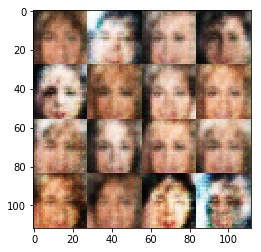

Epoch 0/1... Discriminator Loss: 1.0254... Generator Loss: 1.1391
Epoch 0/1... Discriminator Loss: 1.0184... Generator Loss: 0.9974
Epoch 0/1... Discriminator Loss: 1.1541... Generator Loss: 1.2758
Epoch 0/1... Discriminator Loss: 1.0473... Generator Loss: 1.0445
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 1.1599


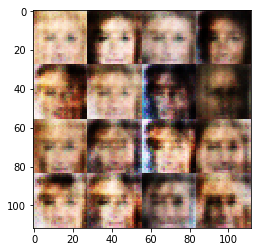

Epoch 0/1... Discriminator Loss: 1.0423... Generator Loss: 1.0651
Epoch 0/1... Discriminator Loss: 1.1232... Generator Loss: 1.0694
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 0.9313
Epoch 0/1... Discriminator Loss: 0.8269... Generator Loss: 1.6213
Epoch 0/1... Discriminator Loss: 1.1151... Generator Loss: 1.1084


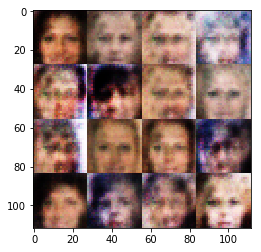

Epoch 0/1... Discriminator Loss: 1.0032... Generator Loss: 0.9072
Epoch 0/1... Discriminator Loss: 0.9138... Generator Loss: 1.3456
Epoch 0/1... Discriminator Loss: 0.9889... Generator Loss: 1.3092
Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 0.9904
Epoch 0/1... Discriminator Loss: 1.3368... Generator Loss: 0.6154


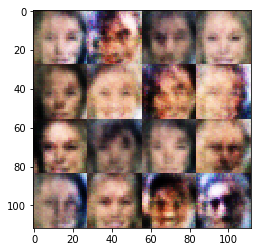

Epoch 0/1... Discriminator Loss: 1.1722... Generator Loss: 0.8308
Epoch 0/1... Discriminator Loss: 1.2758... Generator Loss: 0.7957
Epoch 0/1... Discriminator Loss: 1.2086... Generator Loss: 1.5772
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 1.2063
Epoch 0/1... Discriminator Loss: 1.2109... Generator Loss: 0.8572


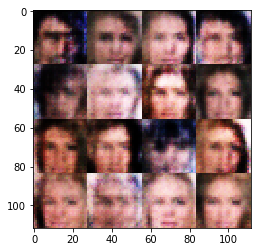

Epoch 0/1... Discriminator Loss: 0.9327... Generator Loss: 1.1994
Epoch 0/1... Discriminator Loss: 1.2138... Generator Loss: 1.3732
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 1.3546
Epoch 0/1... Discriminator Loss: 1.3638... Generator Loss: 0.6133
Epoch 0/1... Discriminator Loss: 0.9471... Generator Loss: 1.3124


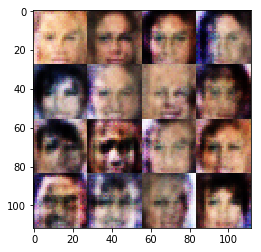

Epoch 0/1... Discriminator Loss: 0.9807... Generator Loss: 1.1738
Epoch 0/1... Discriminator Loss: 1.0882... Generator Loss: 0.8777
Epoch 0/1... Discriminator Loss: 1.1338... Generator Loss: 1.0450
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 1.2485
Epoch 0/1... Discriminator Loss: 1.0919... Generator Loss: 1.1642


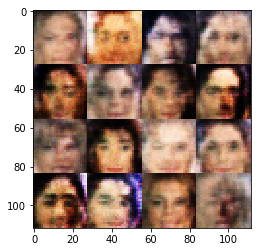

Epoch 0/1... Discriminator Loss: 1.2848... Generator Loss: 0.8795
Epoch 0/1... Discriminator Loss: 1.1850... Generator Loss: 0.7704
Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 1.0028
Epoch 0/1... Discriminator Loss: 0.9212... Generator Loss: 1.5722
Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 1.4977


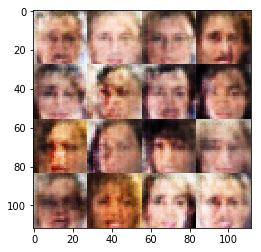

Epoch 0/1... Discriminator Loss: 1.1559... Generator Loss: 0.7989
Epoch 0/1... Discriminator Loss: 1.0442... Generator Loss: 1.4771
Epoch 0/1... Discriminator Loss: 1.3239... Generator Loss: 1.5367
Epoch 0/1... Discriminator Loss: 0.8833... Generator Loss: 1.1798
Epoch 0/1... Discriminator Loss: 0.9984... Generator Loss: 1.0565


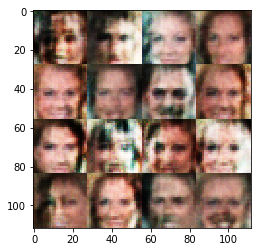

Epoch 0/1... Discriminator Loss: 1.0403... Generator Loss: 1.5623
Epoch 0/1... Discriminator Loss: 1.3552... Generator Loss: 0.7610
Epoch 0/1... Discriminator Loss: 0.9465... Generator Loss: 1.2238
Epoch 0/1... Discriminator Loss: 0.8756... Generator Loss: 1.5114
Epoch 0/1... Discriminator Loss: 1.2614... Generator Loss: 1.2595


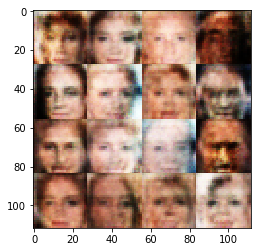

Epoch 0/1... Discriminator Loss: 1.0460... Generator Loss: 1.0173
Epoch 0/1... Discriminator Loss: 1.1582... Generator Loss: 0.9191
Epoch 0/1... Discriminator Loss: 1.0516... Generator Loss: 1.0909
Epoch 0/1... Discriminator Loss: 1.0902... Generator Loss: 0.8820
Epoch 0/1... Discriminator Loss: 0.9834... Generator Loss: 1.0087


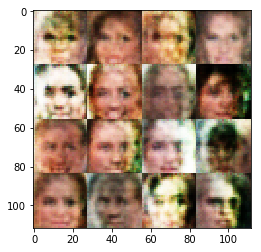

Epoch 0/1... Discriminator Loss: 1.0638... Generator Loss: 1.5596
Epoch 0/1... Discriminator Loss: 1.0804... Generator Loss: 1.4113
Epoch 0/1... Discriminator Loss: 1.0422... Generator Loss: 0.9753
Epoch 0/1... Discriminator Loss: 0.9713... Generator Loss: 1.3784
Epoch 0/1... Discriminator Loss: 0.9659... Generator Loss: 1.1759


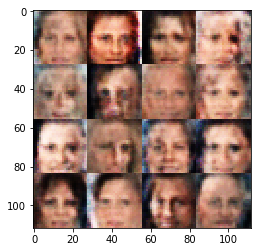

Epoch 0/1... Discriminator Loss: 1.1099... Generator Loss: 1.4620
Epoch 0/1... Discriminator Loss: 1.0280... Generator Loss: 0.9273
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.7424
Epoch 0/1... Discriminator Loss: 0.9038... Generator Loss: 1.1389
Epoch 0/1... Discriminator Loss: 1.3347... Generator Loss: 0.9069


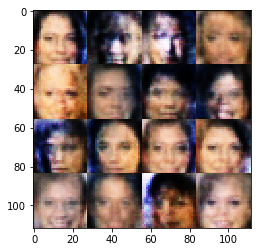

Epoch 0/1... Discriminator Loss: 1.1027... Generator Loss: 1.1291
Epoch 0/1... Discriminator Loss: 1.1377... Generator Loss: 1.6174
Epoch 0/1... Discriminator Loss: 1.0815... Generator Loss: 0.9680
Epoch 0/1... Discriminator Loss: 0.8931... Generator Loss: 1.2347
Epoch 0/1... Discriminator Loss: 1.1852... Generator Loss: 1.0363


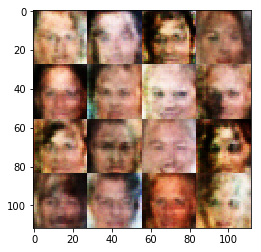

Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 1.2644
Epoch 0/1... Discriminator Loss: 1.0657... Generator Loss: 1.3143
Epoch 0/1... Discriminator Loss: 0.9174... Generator Loss: 1.3271
Epoch 0/1... Discriminator Loss: 1.2713... Generator Loss: 0.6911
Epoch 0/1... Discriminator Loss: 1.1113... Generator Loss: 1.1786


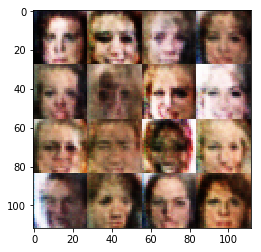

Epoch 0/1... Discriminator Loss: 1.1445... Generator Loss: 0.8633
Epoch 0/1... Discriminator Loss: 1.0940... Generator Loss: 1.0136
Epoch 0/1... Discriminator Loss: 1.1202... Generator Loss: 0.8862
Epoch 0/1... Discriminator Loss: 0.8799... Generator Loss: 1.3113
Epoch 0/1... Discriminator Loss: 1.1184... Generator Loss: 1.0738


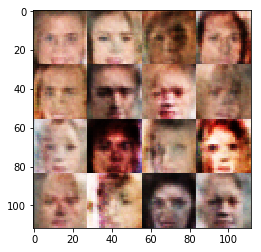

Epoch 0/1... Discriminator Loss: 1.1467... Generator Loss: 0.9064
Epoch 0/1... Discriminator Loss: 1.1408... Generator Loss: 0.8827
Epoch 0/1... Discriminator Loss: 1.1389... Generator Loss: 1.4959
Epoch 0/1... Discriminator Loss: 1.0896... Generator Loss: 0.9178
Epoch 0/1... Discriminator Loss: 1.2076... Generator Loss: 0.7632


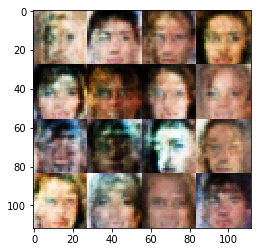

Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 1.0718
Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 1.2754
Epoch 0/1... Discriminator Loss: 1.0049... Generator Loss: 1.1905
Epoch 0/1... Discriminator Loss: 0.9432... Generator Loss: 1.3669
Epoch 0/1... Discriminator Loss: 0.9257... Generator Loss: 1.1379


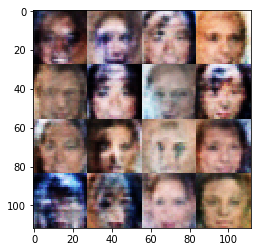

Epoch 0/1... Discriminator Loss: 1.1314... Generator Loss: 0.9489
Epoch 0/1... Discriminator Loss: 1.0515... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.1247... Generator Loss: 1.0365
Epoch 0/1... Discriminator Loss: 0.8942... Generator Loss: 1.2809
Epoch 0/1... Discriminator Loss: 1.3026... Generator Loss: 0.7553


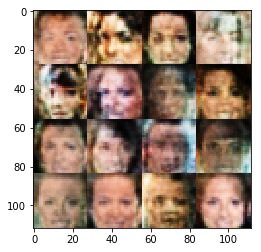

Epoch 0/1... Discriminator Loss: 0.9289... Generator Loss: 1.0930
Epoch 0/1... Discriminator Loss: 0.9589... Generator Loss: 1.0875
Epoch 0/1... Discriminator Loss: 1.0420... Generator Loss: 1.4938
Epoch 0/1... Discriminator Loss: 1.0438... Generator Loss: 1.1715
Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 1.0011


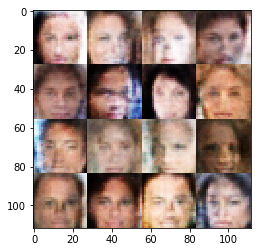

Epoch 0/1... Discriminator Loss: 0.9821... Generator Loss: 1.0977
Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 1.1962
Epoch 0/1... Discriminator Loss: 1.1274... Generator Loss: 0.8902
Epoch 0/1... Discriminator Loss: 1.0476... Generator Loss: 1.0364
Epoch 0/1... Discriminator Loss: 1.1055... Generator Loss: 1.2003


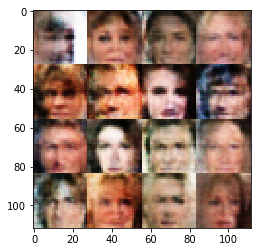

Epoch 0/1... Discriminator Loss: 1.0461... Generator Loss: 1.1086
Epoch 0/1... Discriminator Loss: 0.9681... Generator Loss: 1.2306
Epoch 0/1... Discriminator Loss: 1.1475... Generator Loss: 1.0450
Epoch 0/1... Discriminator Loss: 0.9399... Generator Loss: 1.1934
Epoch 0/1... Discriminator Loss: 1.0547... Generator Loss: 0.9825


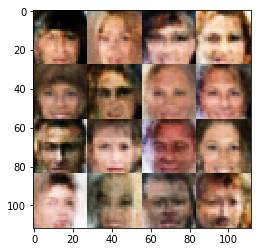

Epoch 0/1... Discriminator Loss: 0.8970... Generator Loss: 1.3607
Epoch 0/1... Discriminator Loss: 1.2390... Generator Loss: 0.7964
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 0.9164
Epoch 0/1... Discriminator Loss: 1.3617... Generator Loss: 0.5493
Epoch 0/1... Discriminator Loss: 1.6561... Generator Loss: 0.4598


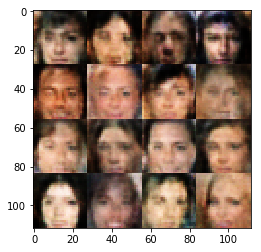

Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 1.0357
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 1.0154
Epoch 0/1... Discriminator Loss: 1.0135... Generator Loss: 1.0389
Epoch 0/1... Discriminator Loss: 1.3067... Generator Loss: 0.8942
Epoch 0/1... Discriminator Loss: 1.0583... Generator Loss: 1.1515


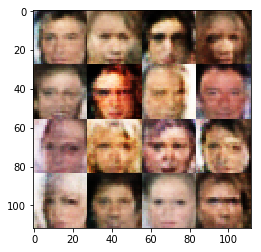

Epoch 0/1... Discriminator Loss: 1.1797... Generator Loss: 0.9049
Epoch 0/1... Discriminator Loss: 1.0590... Generator Loss: 0.9786
Epoch 0/1... Discriminator Loss: 1.2405... Generator Loss: 1.5596
Epoch 0/1... Discriminator Loss: 0.9711... Generator Loss: 1.0719
Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 1.1507


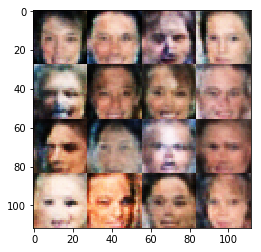

Epoch 0/1... Discriminator Loss: 0.9223... Generator Loss: 1.6558
Epoch 0/1... Discriminator Loss: 1.1987... Generator Loss: 0.8992
Epoch 0/1... Discriminator Loss: 1.2165... Generator Loss: 0.9141
Epoch 0/1... Discriminator Loss: 1.1185... Generator Loss: 1.0580
Epoch 0/1... Discriminator Loss: 1.0288... Generator Loss: 1.0653


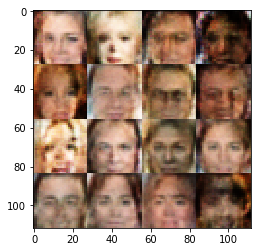

Epoch 0/1... Discriminator Loss: 1.0219... Generator Loss: 1.2075
Epoch 0/1... Discriminator Loss: 1.0849... Generator Loss: 0.8198
Epoch 0/1... Discriminator Loss: 0.9577... Generator Loss: 1.0896
Epoch 0/1... Discriminator Loss: 1.1495... Generator Loss: 0.7743
Epoch 0/1... Discriminator Loss: 0.9992... Generator Loss: 1.2911


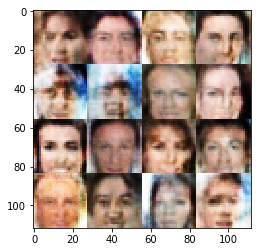

Epoch 0/1... Discriminator Loss: 0.9599... Generator Loss: 1.1410
Epoch 0/1... Discriminator Loss: 1.0592... Generator Loss: 0.9659
Epoch 0/1... Discriminator Loss: 0.8777... Generator Loss: 1.3147
Epoch 0/1... Discriminator Loss: 0.8923... Generator Loss: 1.2793
Epoch 0/1... Discriminator Loss: 1.0026... Generator Loss: 1.1544


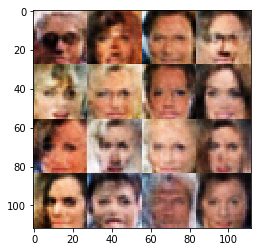

Epoch 0/1... Discriminator Loss: 1.1811... Generator Loss: 1.0154
Epoch 0/1... Discriminator Loss: 1.0089... Generator Loss: 1.1826
Epoch 0/1... Discriminator Loss: 1.0949... Generator Loss: 1.0530
Epoch 0/1... Discriminator Loss: 0.7640... Generator Loss: 1.4972
Epoch 0/1... Discriminator Loss: 1.0715... Generator Loss: 1.1104


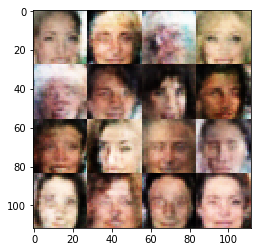

Epoch 0/1... Discriminator Loss: 0.9826... Generator Loss: 1.0364
Epoch 0/1... Discriminator Loss: 1.0736... Generator Loss: 1.2099
Epoch 0/1... Discriminator Loss: 1.0050... Generator Loss: 1.3434
Epoch 0/1... Discriminator Loss: 1.2920... Generator Loss: 0.5850
Epoch 0/1... Discriminator Loss: 1.0820... Generator Loss: 0.8911


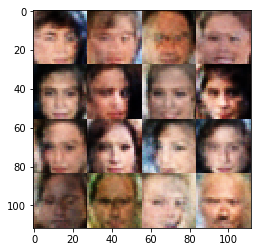

Epoch 0/1... Discriminator Loss: 0.9555... Generator Loss: 1.1006
Epoch 0/1... Discriminator Loss: 1.2984... Generator Loss: 0.6939
Epoch 0/1... Discriminator Loss: 0.9776... Generator Loss: 1.2906
Epoch 0/1... Discriminator Loss: 1.2156... Generator Loss: 0.8686
Epoch 0/1... Discriminator Loss: 1.1285... Generator Loss: 0.8313


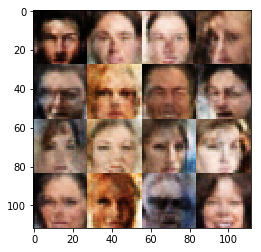

Epoch 0/1... Discriminator Loss: 0.9974... Generator Loss: 1.1144
Epoch 0/1... Discriminator Loss: 1.1054... Generator Loss: 1.0188
Epoch 0/1... Discriminator Loss: 1.1391... Generator Loss: 0.8585
Epoch 0/1... Discriminator Loss: 1.0687... Generator Loss: 1.1349
Epoch 0/1... Discriminator Loss: 1.0799... Generator Loss: 0.8449


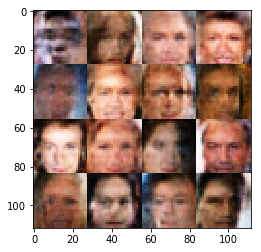

Epoch 0/1... Discriminator Loss: 1.1189... Generator Loss: 0.8955
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.0879
Epoch 0/1... Discriminator Loss: 1.0393... Generator Loss: 0.9545
Epoch 0/1... Discriminator Loss: 1.2999... Generator Loss: 0.8387
Epoch 0/1... Discriminator Loss: 0.9694... Generator Loss: 0.9787


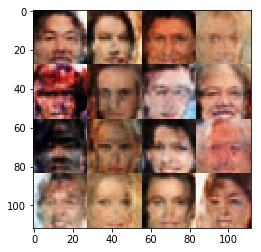

Epoch 0/1... Discriminator Loss: 0.9389... Generator Loss: 1.0650
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 1.2224
Epoch 0/1... Discriminator Loss: 1.1644... Generator Loss: 0.7646
Epoch 0/1... Discriminator Loss: 0.9926... Generator Loss: 1.2934
Epoch 0/1... Discriminator Loss: 0.7750... Generator Loss: 1.4791


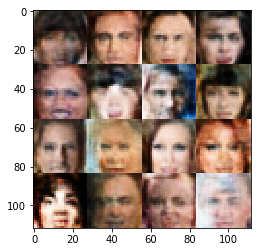

Epoch 0/1... Discriminator Loss: 1.1528... Generator Loss: 0.8809
Epoch 0/1... Discriminator Loss: 1.2179... Generator Loss: 0.8749
Epoch 0/1... Discriminator Loss: 1.0682... Generator Loss: 0.9566
Epoch 0/1... Discriminator Loss: 1.3350... Generator Loss: 0.6051
Epoch 0/1... Discriminator Loss: 0.8270... Generator Loss: 1.2338


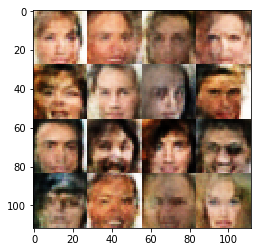

Epoch 0/1... Discriminator Loss: 0.9878... Generator Loss: 1.0404
Epoch 0/1... Discriminator Loss: 1.1982... Generator Loss: 0.7085
Epoch 0/1... Discriminator Loss: 1.1547... Generator Loss: 1.2998
Epoch 0/1... Discriminator Loss: 0.8816... Generator Loss: 1.2433
Epoch 0/1... Discriminator Loss: 0.7460... Generator Loss: 1.3320


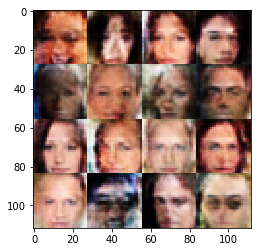

Epoch 0/1... Discriminator Loss: 1.0126... Generator Loss: 1.3004
Epoch 0/1... Discriminator Loss: 1.2089... Generator Loss: 0.7822
Epoch 0/1... Discriminator Loss: 0.9589... Generator Loss: 1.0172
Epoch 0/1... Discriminator Loss: 1.0885... Generator Loss: 1.0580
Epoch 0/1... Discriminator Loss: 1.2425... Generator Loss: 0.6614


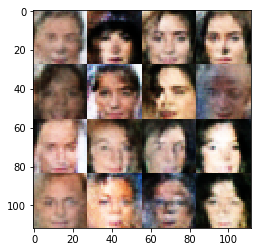

Epoch 0/1... Discriminator Loss: 1.3617... Generator Loss: 0.6667
Epoch 0/1... Discriminator Loss: 1.0043... Generator Loss: 1.0910
Epoch 0/1... Discriminator Loss: 0.9863... Generator Loss: 1.2041
Epoch 0/1... Discriminator Loss: 0.9485... Generator Loss: 1.0243
Epoch 0/1... Discriminator Loss: 1.0024... Generator Loss: 1.2786


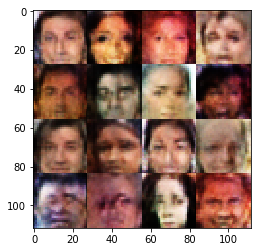

Epoch 0/1... Discriminator Loss: 1.3347... Generator Loss: 0.7390
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 1.1624
Epoch 0/1... Discriminator Loss: 1.0049... Generator Loss: 0.9535
Epoch 0/1... Discriminator Loss: 0.9849... Generator Loss: 1.3427
Epoch 0/1... Discriminator Loss: 1.2176... Generator Loss: 1.0031


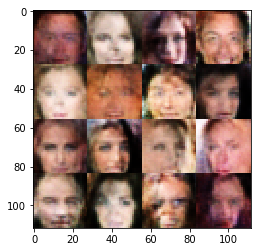

Epoch 0/1... Discriminator Loss: 0.9802... Generator Loss: 1.0623
Epoch 0/1... Discriminator Loss: 1.1742... Generator Loss: 0.7023
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.1963
Epoch 0/1... Discriminator Loss: 1.0848... Generator Loss: 1.1087
Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 1.3064


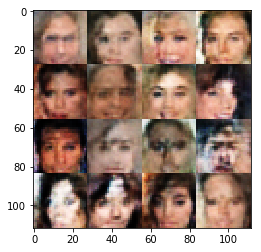

Epoch 0/1... Discriminator Loss: 1.1170... Generator Loss: 0.9271
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 1.0572
Epoch 0/1... Discriminator Loss: 0.9258... Generator Loss: 1.2085
Epoch 0/1... Discriminator Loss: 1.0236... Generator Loss: 0.9558
Epoch 0/1... Discriminator Loss: 0.8842... Generator Loss: 1.2988


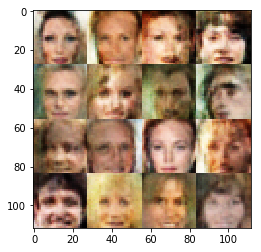

Epoch 0/1... Discriminator Loss: 0.7980... Generator Loss: 1.6115
Epoch 0/1... Discriminator Loss: 1.2360... Generator Loss: 0.9105
Epoch 0/1... Discriminator Loss: 1.1944... Generator Loss: 0.8880
Epoch 0/1... Discriminator Loss: 1.0022... Generator Loss: 1.0687
Epoch 0/1... Discriminator Loss: 1.1540... Generator Loss: 0.7100


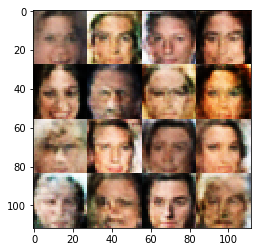

Epoch 0/1... Discriminator Loss: 1.0848... Generator Loss: 1.1014
Epoch 0/1... Discriminator Loss: 1.3047... Generator Loss: 0.6771
Epoch 0/1... Discriminator Loss: 1.1790... Generator Loss: 0.9017
Epoch 0/1... Discriminator Loss: 1.1873... Generator Loss: 0.7729
Epoch 0/1... Discriminator Loss: 0.9450... Generator Loss: 1.1906


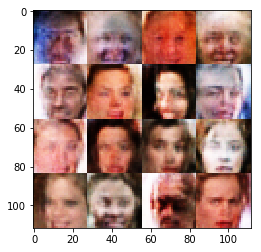

Epoch 0/1... Discriminator Loss: 1.0583... Generator Loss: 1.0601
Epoch 0/1... Discriminator Loss: 1.1647... Generator Loss: 0.8120
Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 1.1885
Epoch 0/1... Discriminator Loss: 0.9548... Generator Loss: 0.9961
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 1.0735


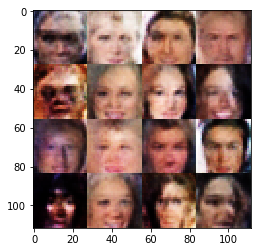

Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.5567
Epoch 0/1... Discriminator Loss: 0.9020... Generator Loss: 1.1584
Epoch 0/1... Discriminator Loss: 0.8941... Generator Loss: 1.4240
Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 1.2446
Epoch 0/1... Discriminator Loss: 0.8133... Generator Loss: 1.3603


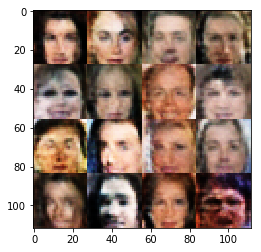

Epoch 0/1... Discriminator Loss: 0.9121... Generator Loss: 1.2538
Epoch 0/1... Discriminator Loss: 0.9517... Generator Loss: 1.0302
Epoch 0/1... Discriminator Loss: 0.9731... Generator Loss: 0.9814
Epoch 0/1... Discriminator Loss: 0.9654... Generator Loss: 1.1422
Epoch 0/1... Discriminator Loss: 1.0925... Generator Loss: 0.7900


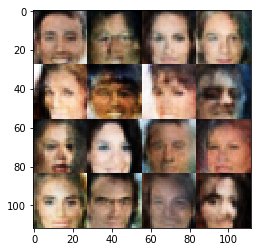

Epoch 0/1... Discriminator Loss: 1.1055... Generator Loss: 0.8058
Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 1.2260
Epoch 0/1... Discriminator Loss: 0.8939... Generator Loss: 1.1571
Epoch 0/1... Discriminator Loss: 1.0684... Generator Loss: 1.0520
Epoch 0/1... Discriminator Loss: 0.9533... Generator Loss: 1.4531


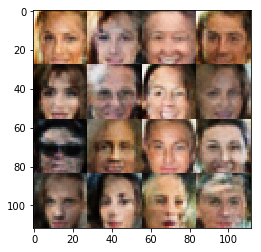

Epoch 0/1... Discriminator Loss: 0.7456... Generator Loss: 1.5693
Epoch 0/1... Discriminator Loss: 0.8162... Generator Loss: 1.3246
Epoch 0/1... Discriminator Loss: 1.1508... Generator Loss: 0.7583
Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 1.0845
Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 0.8452


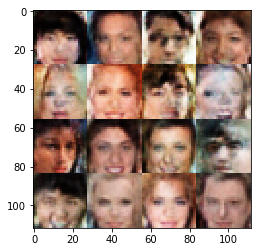

Epoch 0/1... Discriminator Loss: 0.9021... Generator Loss: 1.3005
Epoch 0/1... Discriminator Loss: 0.9800... Generator Loss: 0.8513
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 0.8160
Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 0.9457
Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 0.8569


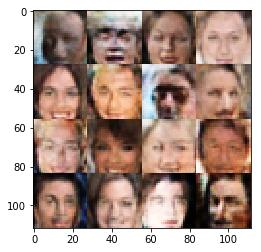

Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 0.9533
Epoch 0/1... Discriminator Loss: 1.3452... Generator Loss: 0.5440
Epoch 0/1... Discriminator Loss: 0.8799... Generator Loss: 1.2293
Epoch 0/1... Discriminator Loss: 0.9420... Generator Loss: 1.1493
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 0.7627


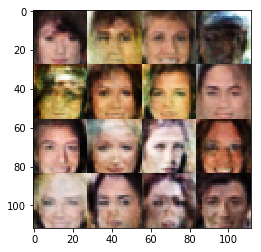

Epoch 0/1... Discriminator Loss: 1.0116... Generator Loss: 0.8765
Epoch 0/1... Discriminator Loss: 0.8918... Generator Loss: 1.1270
Epoch 0/1... Discriminator Loss: 1.0896... Generator Loss: 0.8859
Epoch 0/1... Discriminator Loss: 0.8438... Generator Loss: 1.4724
Epoch 0/1... Discriminator Loss: 1.3445... Generator Loss: 0.6056


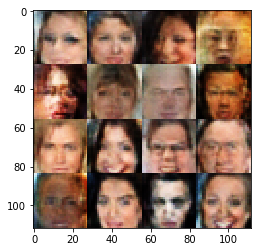

Epoch 0/1... Discriminator Loss: 0.9925... Generator Loss: 1.1132


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.